# Scraped Fixtures API Example

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/ScrapedFixturesAPI/Scraped%20Fixtures%20API%20Example.ipynb) 

- Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [2]:
signal_ocean_api_key = '' # replace with your subscription key

### Scraped Fixtures API  
The goal of Scraped Fixtures API is to collect and return the scraped fixtures by the given filters. 
The data are requested by using the get_fixtures() function with the following arguments.

Required input arguments are: 
* vessel_type: The vessel type
* received_date_from :Earliest date the fixture received.

Optional arguments:
* port_id: The loading port id
* vessel_class_id: The vessel class id
* received_date_to: Latest date the fixture received.
* updated_date_from: Earliest date the fixture updated. Cannot be combined with 'received_date_from'
* updated_date_to: Latest date the fixture updated. Cannot be combined with 'received_date_to'

Other optional arguments:
* include_fixture_details: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None):
    * parsed_part_id, line_from, line_to, in_line_order, source 
* include_scraped_fields: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None):
    * scraped_vessel_name, scraped_deadweight, scraped_year_build, scraped_laycan, scraped_load, scraped_load2, scraped_discharge, scraped_discharge2, scraped_discharge_options, scraped_charterer, scraped_cargo_type, scraped_quantity, scraped_rate, scraped_rate_options, scraped_delivery_date, scraped_delivery, scraped_redelivery_from, scraped_redelivery_to
* include_vessel_details: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None):
    * vessel_name, deadweight, year_build, liquid_capacity, vessel_type_id, vessel_type, vessel_class, commercial_operator_id, commercial_operator
* include_labels: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None):
    * load_name,load_name2, load_taxonomy, load_taxonomy2, discharge_name, discharge_name2, discharge_taxonomy, discharge_taxonomy2, charterer, cargo_type, cargo_group, open_taxonomy, redelivery_from_name, delivery_name, open_geo_name, redelivery_from_taxonomy, redelivery_to_name, redelivery_to_taxonomy, charterer_type, fixture_status
* include_content: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None):
    * content
* include_sender: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None): 
    * sender
* include_debug_info: Boolean. If this field is True then the following columns will be incuded in the response (otherwise they will be None):
    * is_private, is_invalidated, is_partial

## Setup

### Import libraries

In [3]:
%%capture
%pip install signal-ocean

import pandas as pd
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px


from signal_ocean import Connection
from signal_ocean.scraped_fixtures import ScrapedFixturesAPI

## Functions

Plot functions
* Plot the top k senders with VLCC in the last 7 days with loading port in Ras Tanura
* Plot the daily number of fixtures for Ras Tanura/VLCC

In [4]:
def plot_senders(results, k):

    data_aggr = results \
              .groupby(['sender'])['fixture_id'] \
              .unique().reset_index()

    data_aggr['unique_fixture_ids'] = data_aggr \
                                            .apply(lambda x: len(x.fixture_id),axis=1)
    top_k = data_aggr \
          .sort_values('unique_fixture_ids') \
          .tail(k)
  
    fig = px.bar(top_k, 
               y='sender', 
               x='unique_fixture_ids' ,
               orientation='h',
               title="Top {} senders, VLCC" \
                              .format(k)
               )
    
  
    fig.update_layout(
      xaxis_title="Number of fixtures",
      yaxis_title="Senders"
    )
    fig.show()

In [5]:
def plot_daily_fixtures(results):

    
    results['received_date'] = pd.to_datetime(results['received_date'])
    results['received_date'] = results['received_date'].dt.date
    fixtures_daily = results.groupby('received_date')['fixture_id'].unique().reset_index()
    fixtures_daily['unique_fixture_ids'] = fixtures_daily \
                                            .apply(lambda x: len(x.fixture_id),axis=1)
    fixtures_daily = fixtures_daily.sort_values('received_date')
    fig = px.bar(
      fixtures_daily, 
      title="Daily Fixtures",
      x='received_date', 
      y='unique_fixture_ids', 
    )
    fig.update_layout(
      yaxis_title="Number of fixtures",
      xaxis_title="Received Date"
    )
    fig.show()

## Results

### Example 

In the following example will extract the fixtures for the VLCC in the last 7 days with loading port in Ras Tanura

In [6]:
vessel_type_id = 1
last_days = 7
vessel_class_id = 84 
port_id = 3778 
date_from = date.today() - timedelta(days=last_days)
date_to = date.today()

connection = Connection(signal_ocean_api_key)
api = ScrapedFixturesAPI(connection)
scraped_fixtures = api.get_fixtures(
    received_date_from = date_from,
    received_date_to = date_to,
    vessel_type = vessel_type_id,
    port_id = port_id,
    vessel_class_id = vessel_class_id
)

results = pd.DataFrame([v.__dict__ for v in scraped_fixtures])
if not results.empty:
    results.head(5)
else:
    print('No scraped fixtures for the given filters')

#### Plot top 10 senders

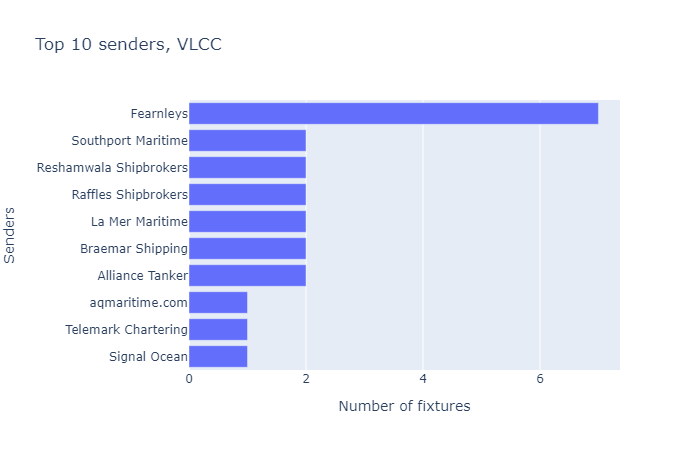

In [7]:
if not results.empty:
    plot_senders(results, k=10)

#### Get the daily number of fixtures for Ras Tanura/VLCC

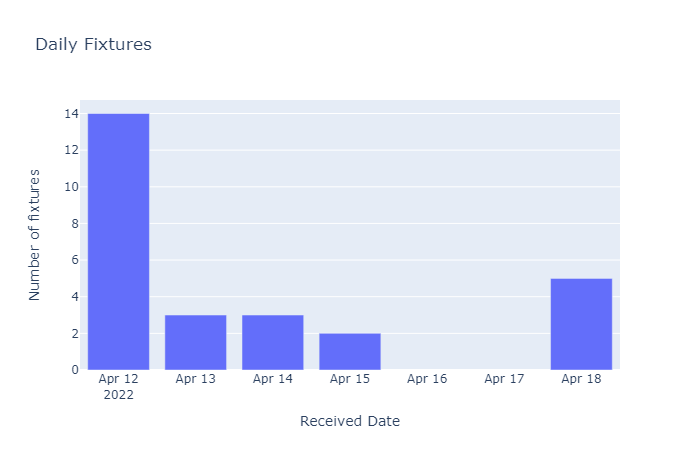

In [8]:
if not results.empty:
    plot_daily_fixtures(results)

#### Export Results to CSV

In [9]:
output_path = '' # Change output_path with your path
filename = 'vlcc_one_week_scraped_fix.csv'
if not results.empty:
    results.to_csv(output_path+filename,index=False)